#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_val_score 

In [2]:
train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

In [3]:
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


## Линейная регрессия  + Дерево решений (регрессия)

In [21]:
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

In [22]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','grade','home_ownership','inq_last_6mths','mths_since_last_delinq','pub_rec','revol_bal','revol_util','loan_status','tot_coll_amt'] ] # параметры
x['mths_since_last_delinq'] = x['mths_since_last_delinq'].fillna(0)
x['revol_util'] = x['revol_util'].fillna(0)
x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,loan_status,tot_coll_amt
0,70000.0,B,MORTGAGE,1.0,0.0,3.0,12540.0,61.2,1,0.0
1,52260.0,A,MORTGAGE,0.0,0.0,0.0,3730.0,26.3,1,0.0
2,67500.0,B,RENT,0.0,0.0,0.0,11769.0,60.5,1,193.0
3,21600.0,C,MORTGAGE,0.0,47.0,0.0,6797.0,46.9,0,165.0
4,41000.0,B,RENT,0.0,0.0,0.0,14674.0,82.4,1,0.0


In [23]:
label_encoder = LabelEncoder()
categorical_columns = x.columns[x.dtypes == 'object']
for column in categorical_columns:
    x[column] = label_encoder.fit_transform(x[column])
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,loan_status,tot_coll_amt
0,70000.0,1,1,1.0,0.0,3.0,12540.0,61.2,1,0.0
1,52260.0,0,1,0.0,0.0,0.0,3730.0,26.3,1,0.0
2,67500.0,1,5,0.0,0.0,0.0,11769.0,60.5,1,193.0
3,21600.0,2,1,0.0,47.0,0.0,6797.0,46.9,0,165.0
4,41000.0,1,5,0.0,0.0,0.0,14674.0,82.4,1,0.0


In [24]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, max_leaf_nodes = 3000)

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lm, x,  y, cv=5, scoring = 'r2')
scores 

array([0.90836197, 0.9075927 , 0.90881688, 0.9093389 , 0.90978894])

In [26]:
scores = cross_val_score(dec_reg, x,  y, cv=5, scoring = 'r2')# дерево решений
scores 

array([0.91117984, 0.91165976, 0.91173634, 0.91202208, 0.91252753])

## Логическая регрессия

In [27]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','tot_coll_amt'] ] # параметры
x['revol_util'] = x['revol_util'].fillna(0)
x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt
0,70000.0,B,MORTGAGE,1.0,3.0,12540.0,61.2,0.0
1,52260.0,A,MORTGAGE,0.0,0.0,3730.0,26.3,0.0
2,67500.0,B,RENT,0.0,0.0,11769.0,60.5,193.0
3,21600.0,C,MORTGAGE,0.0,0.0,6797.0,46.9,165.0
4,41000.0,B,RENT,0.0,0.0,14674.0,82.4,0.0


In [28]:
label_encoder = LabelEncoder() # категориальные признаки
categorical_columns = x.columns[x.dtypes == 'object']
for column in categorical_columns:
    x[column] = label_encoder.fit_transform(x[column])
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt
0,70000.0,1,1,1.0,3.0,12540.0,61.2,0.0
1,52260.0,0,1,0.0,0.0,3730.0,26.3,0.0
2,67500.0,1,5,0.0,0.0,11769.0,60.5,193.0
3,21600.0,2,1,0.0,0.0,6797.0,46.9,165.0
4,41000.0,1,5,0.0,0.0,14674.0,82.4,0.0


In [29]:
lr = linear_model.LogisticRegression(solver='liblinear', random_state = 42)

In [30]:
scores = cross_val_score(lr, x,  y, cv=5, scoring = 'precision')
scores 

array([0.77756132, 0.77756963, 0.77760847, 0.77757518, 0.77756963])

## Дерево решений (классификация)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
import pydot
import os
os.environ["PATH"] += os.pathsep + 'D:/graphviz-2.38/release/bin'


In [5]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','tot_coll_amt'] ] # параметры
x['revol_util'] = x['revol_util'].fillna(0)
x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt
0,70000.0,B,MORTGAGE,1.0,3.0,12540.0,61.2,0.0
1,52260.0,A,MORTGAGE,0.0,0.0,3730.0,26.3,0.0
2,67500.0,B,RENT,0.0,0.0,11769.0,60.5,193.0
3,21600.0,C,MORTGAGE,0.0,0.0,6797.0,46.9,165.0
4,41000.0,B,RENT,0.0,0.0,14674.0,82.4,0.0


In [6]:
label_encoder = LabelEncoder() # категориальные признаки
categorical_columns = x.columns[x.dtypes == 'object']
for column in categorical_columns:
    x[column] = label_encoder.fit_transform(x[column])
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt
0,70000.0,1,1,1.0,3.0,12540.0,61.2,0.0
1,52260.0,0,1,0.0,0.0,3730.0,26.3,0.0
2,67500.0,1,5,0.0,0.0,11769.0,60.5,193.0
3,21600.0,2,1,0.0,0.0,6797.0,46.9,165.0
4,41000.0,1,5,0.0,0.0,14674.0,82.4,0.0


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42, min_samples_leaf = 3000)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [8]:
scores = cross_val_score(clf_tree, x_train,  y_train, cv=5, scoring = 'precision')
scores

array([0.77692939, 0.77692939, 0.77695711, 0.77695711, 0.77695711])

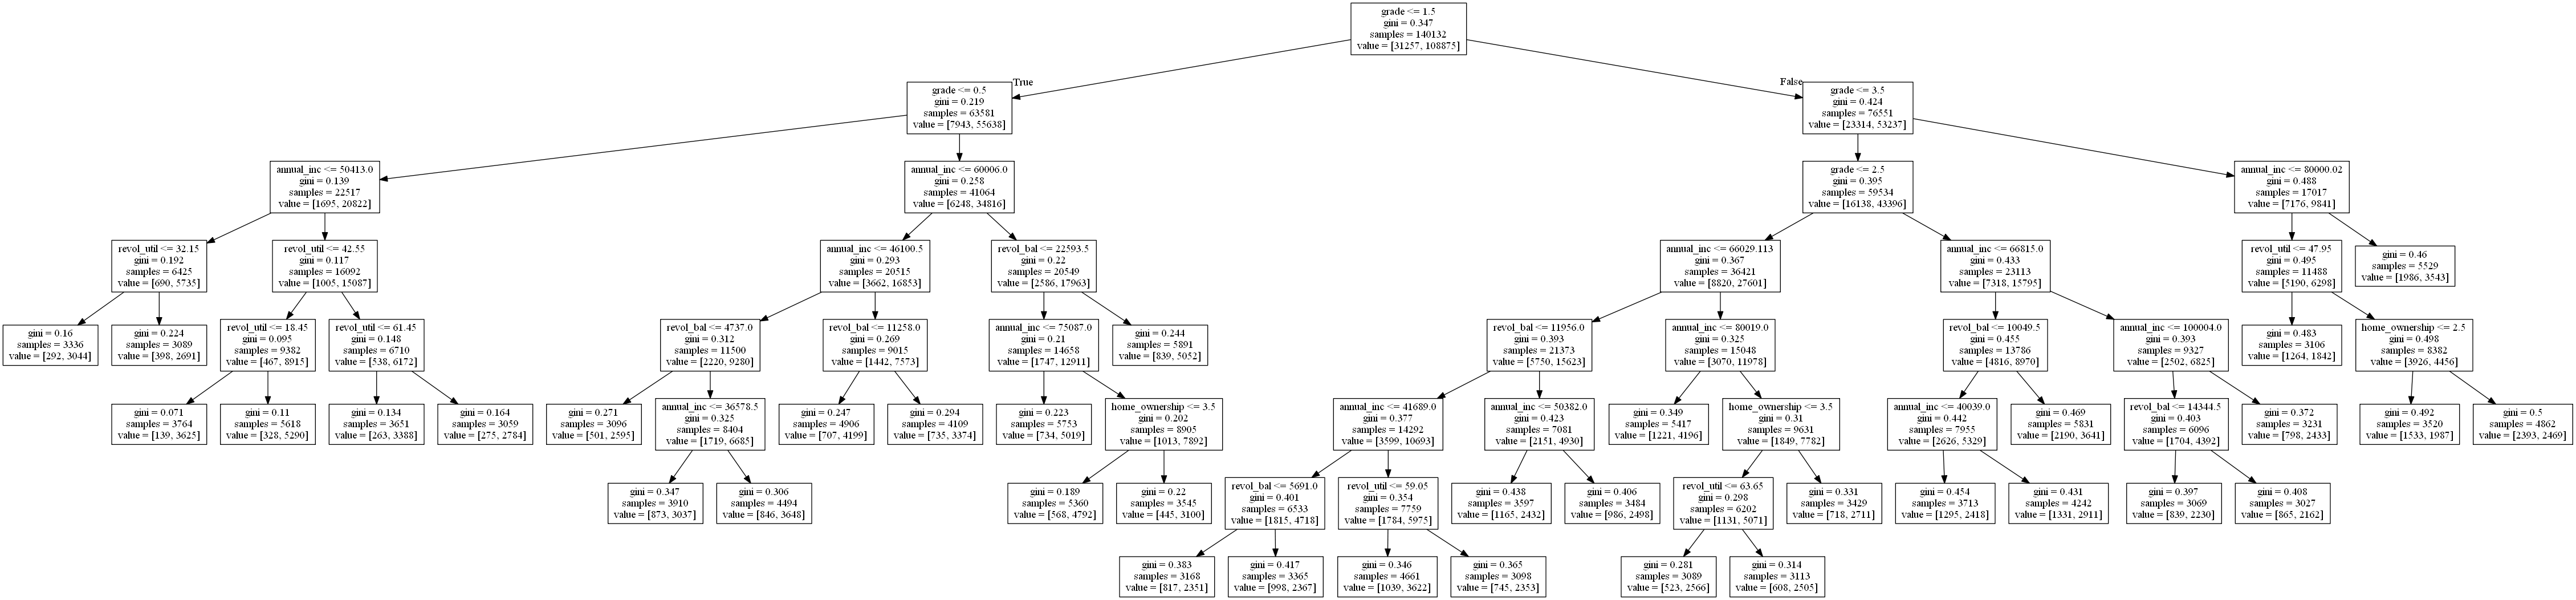

In [9]:
dot_data = StringIO()  
export_graphviz(clf_tree, out_file=dot_data, feature_names=['annual_inc','grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','tot_coll_amt'] )  
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Случайное дерево

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [11]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','tot_coll_amt'] ] # параметры
x['revol_util'] = x['revol_util'].fillna(0)
x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt
0,70000.0,B,MORTGAGE,1.0,3.0,12540.0,61.2,0.0
1,52260.0,A,MORTGAGE,0.0,0.0,3730.0,26.3,0.0
2,67500.0,B,RENT,0.0,0.0,11769.0,60.5,193.0
3,21600.0,C,MORTGAGE,0.0,0.0,6797.0,46.9,165.0
4,41000.0,B,RENT,0.0,0.0,14674.0,82.4,0.0


In [12]:
label_encoder = LabelEncoder() # категориальные признаки
categorical_columns = x.columns[x.dtypes == 'object']
for column in categorical_columns:
    x[column] = label_encoder.fit_transform(x[column])
x.head()

,annual_inc,grade,home_ownership,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt
0,70000.0,1,1,1.0,3.0,12540.0,61.2,0.0
1,52260.0,0,1,0.0,0.0,3730.0,26.3,0.0
2,67500.0,1,5,0.0,0.0,11769.0,60.5,193.0
3,21600.0,2,1,0.0,0.0,6797.0,46.9,165.0
4,41000.0,1,5,0.0,0.0,14674.0,82.4,0.0


In [19]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10,20],
    'min_samples_leaf': [2000,1000,500],
    'n_estimators': [10,100, 200],
    'criterion' : ['gini', 'entropy']
}

In [20]:
rf =  RandomForestClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [22]:
grid_search.fit(x_train,  y_train)
grid_search.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 11.9min finished


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 500,
 'n_estimators': 10}

In [26]:
from sklearn.metrics import precision_score
best_grid = grid_search.best_estimator_
print('Precision score: %.2f' % precision_score(y_test, best_grid.predict(x_test)))

Precision score: 0.78
